La idea del spline cúbico es en vez de hacer una función que me de todos los puntos, lo que hacemos es hacer n funciones entre punto y punto, y las tratamos de hacer con una interpolación de una función cúbica. 

Inspirado en este video: https://youtu.be/yOUst2672qo

In [1]:
using DataFrames
using Plots
using Symbolics

In [2]:
# Path: clase6/splines.ipynb
function build_continuity_coefficients(X, points)

    """
        Given a matrix full of zeros, and of size (4n, 4n), where n is the number of polynomials to be found
        for the cubic spline, this function fills the upper part of the matrix corresponding to the equations 
        that say that the polynomials must be continuous at the intersections of the intervals.

        Arguments:
            X: Matrix of zeros of size (4n, 4n)
            points: Vector of points [x,y] to be interpolated
    """

    # Check that the matrix is square
    size(X, 1) == size(X, 2) || error("The matrix must be square")

    row = 1
    n_intervals = length(points) - 1

    # Fill the upper part of the matrix
    for i in 1:n_intervals
        
        # Columns to be filled
        cols = (4 * i - 3):(4 * i)
        
        # Points to get the coefficients to fill the columns with
        start_point = points[i]
        end_point = points[i + 1]

        X[row, cols] = [start_point[1]^3, start_point[1]^2, start_point[1], 1]
        X[row+1, cols] = [end_point[1]^3, end_point[1]^2, end_point[1], 1]
        row += 2
    end
    

    return X
end

function build_first_derivative_continuity_coefficients(X, points)

    """
        Given a matrix full of zeros, and of size (4n, 4n), where n is the number of polynomials to be found
        for the cubic spline, this function fills the middle part of the matrix corresponding to the equations 
        that say that the first derivative of the polynomials must be continuous at the intersections of the intervals, 
        this is that the first derivative of the polynomial at the end of an interval must be equal to the first derivative
        of the polynomial at the beginning of the next interval.

        Arguments:
            X: Matrix of zeros of size (4n, 4n)
            points: Vector of points [x,y] to be interpolated
    """

    # Check that the matrix is square
    size(X, 1) == size(X, 2) || error("The matrix must be square")

    n_intervals = length(points) - 1
    row = 2*(n_intervals)+ 1  # 2(n -1) + 1 

    # Fill the first mid part part of the matrix
    for i in 1:n_intervals-1
        
        # Columns to be filled
        col1 = (4 * i - 3):(4 * i)
        col2 = (4 * i + 1):(4 * i + 4)

        # Points to get the coefficients to fill the columns with
        start_point = points[i+1]

        X[row, col1] = [-3*start_point[1]^2, -2*start_point[1], -1, 0]
        X[row, col2] = [ 3*start_point[1]^2,    2*start_point[1],    1, 0]

        row += 1
    end
    
    return X
end

function build_second_derivative_continuity_coefficients(X, points)

    # Check that the matrix is square
    size(X, 1) == size(X, 2) || error("The matrix must be square")

    n_intervals = length(points) - 1
    row = 3*(n_intervals) # 3(n-1) = 3(n) -4 +1

    # Fill the second mid part part of the matrix
    for i in 1:n_intervals-1
        
        # Columns to be filled
        col1 = (4 * i - 3):(4 * i)
        col2 = (4 * i + 1):(4 * i + 4)

        # Points to get the coefficients to fill the columns with
        start_point = points[i+1]

        X[row, col1] = [-6*start_point[1], -2, 0, 0]
        X[row, col2] = [ 6*start_point[1],  2, 0, 0]

        row += 1
    end
    
    return X

end

function build_second_derivative_natural_coefficients(X, points)

    # Check that the matrix is square
    size(X, 1) == size(X, 2) || error("The matrix must be square")

    n_intervals = length(points) - 1
    row = 2*(2*(n_intervals+1)-3) + 1  # 2(2(n)-3) + 1

    # Columns to be filled
    col1 = 1:4
    col2 = (n_intervals*4 - 3):(n_intervals*4)

    # Points to get the coefficients to fill the columns with
    start_point = points[1]
    end_point = points[end]

    # Fill the second mid part part of the matrix
    X[row, col1] = [6*start_point[1], 2, 0, 0]
    X[row+1,col2] = [6*end_point[1], 2, 0, 0]

    return X
end

build_second_derivative_natural_coefficients (generic function with 1 method)

In [3]:
function build_matrix(points)
    n_intervals = length(points) - 1

    #matrix of zeros of size (4n, 4n)
    X = zeros(4 * n_intervals, 4 * n_intervals)

    #fill the upper part of the matrix and print the complete matrix
    X = build_continuity_coefficients(X, points)
    X = build_first_derivative_continuity_coefficients(X, points)
    X = build_second_derivative_continuity_coefficients(X, points)
    X = build_second_derivative_natural_coefficients(X, points)

    return X
end

function build_vector(points)

    n_intervals = length(points) - 1

    #vector of zeros of size (4n, 1)
    Y = zeros(4 * n_intervals, 1)


    #fill the upper part of the matrix and print the complete matrix
    Y[1] = points[1][2]
    Y[2*(n_intervals-1)+2] = points[end][2]

    row = 2
    for i in 2:n_intervals
        Y[row] = points[i][2]
        Y[row+1] = points[i][2]
        row += 2
    end

    return Y

end

build_vector (generic function with 1 method)

In [4]:
function build_and_solve_coefficients(points)
    X = build_matrix(points)
    Y = build_vector(points)
    return X\Y
end

function build_cubic_splines(points, x)

    #sort points by x value 
    points = sort(points, by = x -> x[1])
    
    #build and solve the coefficients
    coefficients = build_and_solve_coefficients(points)
    n_intervals = length(points) - 1
    polynomials = []

    #build the polynomials
    for i in 1:n_intervals
        start_point = points[i]
        end_point = points[i+1]
        polynomial = coefficients[4*i-3]*x^3 + coefficients[4*i-2]*x^2 + coefficients[4*i-1]*x + coefficients[4*i]
        push!(polynomials, (Symbolics.build_function(polynomial, x, expression = false) , start_point[1],end_point[1]))
    end
    return polynomials
end


function interpolate(polynomals, x)
    for polynomial in polynomals
        if x >= polynomial[2] && x <= polynomial[3]
            return polynomial[1](x)
        end
    end
    return nothing
end

interpolate (generic function with 1 method)

In [5]:
#list of points to interpolate
points = [[1, 2], [3, 3], [5, 9], [8, 10]]

X = build_matrix(points)
X

12×12 Matrix{Float64}:
   1.0   1.0   1.0  1.0    0.0    0.0   0.0  0.0    0.0   0.0  0.0  0.0
  27.0   9.0   3.0  1.0    0.0    0.0   0.0  0.0    0.0   0.0  0.0  0.0
   0.0   0.0   0.0  0.0   27.0    9.0   3.0  1.0    0.0   0.0  0.0  0.0
   0.0   0.0   0.0  0.0  125.0   25.0   5.0  1.0    0.0   0.0  0.0  0.0
   0.0   0.0   0.0  0.0    0.0    0.0   0.0  0.0  125.0  25.0  5.0  1.0
   0.0   0.0   0.0  0.0    0.0    0.0   0.0  0.0  512.0  64.0  8.0  1.0
 -27.0  -6.0  -1.0  0.0   27.0    6.0   1.0  0.0    0.0   0.0  0.0  0.0
   0.0   0.0   0.0  0.0  -75.0  -10.0  -1.0  0.0   75.0  10.0  1.0  0.0
 -18.0  -2.0   0.0  0.0   18.0    2.0   0.0  0.0    0.0   0.0  0.0  0.0
   0.0   0.0   0.0  0.0  -30.0   -2.0   0.0  0.0   30.0   2.0  0.0  0.0
   6.0   2.0   0.0  0.0    0.0    0.0   0.0  0.0    0.0   0.0  0.0  0.0
   0.0   0.0   0.0  0.0    0.0    0.0   0.0  0.0   48.0   2.0  0.0  0.0

In [6]:
Y = build_vector(points)

12×1 Matrix{Float64}:
  2.0
  3.0
  3.0
  9.0
  9.0
 10.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0

In [7]:
ans = build_and_solve(points)

UndefVarError: UndefVarError: `build_and_solve` not defined

In [8]:
@variables x
polynomials = build_cubic_splines(points, x)

3-element Vector{Any}:
 (RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:x,), Symbolics.var"#_RGF_ModTag", Symbolics.var"#_RGF_ModTag", (0xfece0eee, 0x17bb2fae, 0x83ed2bf5, 0x22f035d6, 0x190a3aa4), Expr}(quote
    #= /home/dave/.julia/packages/SymbolicUtils/Oyu8Z/src/code.jl:373 =#
    #= /home/dave/.julia/packages/SymbolicUtils/Oyu8Z/src/code.jl:374 =#
    #= /home/dave/.julia/packages/SymbolicUtils/Oyu8Z/src/code.jl:375 =#
    (+)((+)((+)(2.0986842105263146, (*)(0.30043859649122845, x)), (*)(0.19956140350877175, (^)(x, 3))), (*)(-0.5986842105263153, (^)(x, 2)))
end), 1, 3)
 (RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:x,), Symbolics.var"#_RGF_ModTag", Symbolics.var"#_RGF_ModTag", (0x158fa4aa, 0x49e786aa, 0x9f6d0402, 0x87affdc6, 0xe1cd478b), Expr}(quote
    #= /home/dave/.julia/packages/SymbolicUtils/Oyu8Z/src/code.jl:373 =#
    #= /home/dave/.julia/packages/SymbolicUtils/Oyu8Z/src/code.jl:374 =#
    #= /home/dave/.julia/packages/SymbolicUtils/Oyu8Z/src/code.jl:375 =#
  

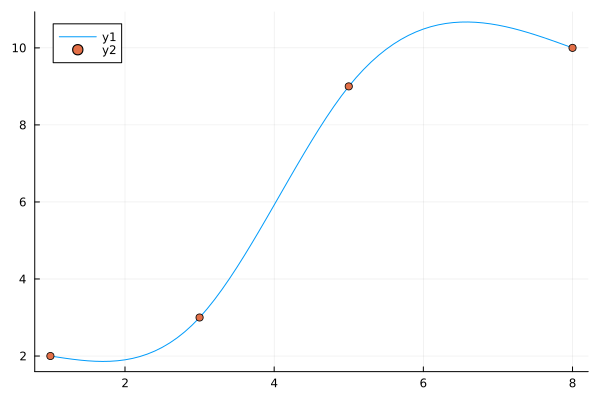

In [11]:
pts = [[pt, interpolate(polynomials, pt)] for pt = 1:0.1:8]

x = [pt[1] for pt in pts]
y = [pt[2] for pt in pts]

plot(x,y)
#scatter the original points
scatter!([pt[1] for pt in points], [pt[2] for pt in points])